In [1]:
%matplotlib widget
import nest
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from nest import raster_plot


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: May 24 2024 10:11:53

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [21]:
data = np.load('/home/justidy1/LabCode/IctalPlaceCell/data/line_maze_data.npz', allow_pickle=True)
wh = 1
pf_CA3 = data['all_pf_CA3'][wh]
pf_CA1 = data['all_pf_CA1'][wh]

ictal = False
if ictal:
    conn_CA3_to_CA3=data['conn_CA3_to_CA3_ictal'][wh]
    conn_CA3_to_CA1=data['conn_CA3_to_CA1_ictal'][wh]
else:
    conn_CA3_to_CA3=data['conn_CA3_to_CA3_controls'][wh]
    conn_CA3_to_CA1=data['conn_CA3_to_CA1_controls'][wh]

def stim_cue_net(conn_CA3_to_CA3,conn_CA3_to_CA1,
                 sim_time,cue_location,cue_time,cue_duration=20,cue_rate=30,cue_weight=50,
                 seed=1234):
    # making a new newtork
    nest.ResetKernel()
    nest.local_num_threads = 16
    nest.rng_seed=seed

    # Create CA3 and CA1 populations of adaptive exponential integrate-and-fire neurons
    N_pyr = 1250
    tau_decay_pyr_e = 9.0
    tau_rise_pyr_e = 1.0
    tau_decay_pyr_i = 3.0
    tau_rise_pyr_i = 0.3
    tau_decay_gc = 5.4
    tau_rise_gc = 0.65

    pyr_spec = {'C_m':180,'g_L':4.3,'E_L':-75,'Delta_T':4.23,'V_th':-24,'V_peak':-3.25,'V_reset':-29.7,'t_ref':5.9,
                'tau_w':84.93,'a':-0.27,'b':206.84,'E_rev':[0,-90,0],
                'tau_rise':[tau_rise_pyr_e,tau_rise_pyr_i,tau_rise_gc],'tau_decay':[tau_decay_pyr_e,tau_decay_pyr_i,tau_decay_gc]}
    CA3_pyr_aeif = nest.Create("aeif_cond_beta_multisynapse", N_pyr, pyr_spec)
    CA1_pyr_aeif = nest.Create("aeif_cond_beta_multisynapse", N_pyr, pyr_spec)
    # make interneurons in CA3 and CA1
    N_int = 250
    int_spec = {'C_m':118,'g_L':7.5,'E_L':-74,'Delta_T':4.6,'V_th':-57.7,'V_peak':-34.78,'V_reset':-65,'t_ref':1,
                'tau_w':178.58,'a':3.05,'b':0.91,'E_rev':[0,-90],
                'tau_rise':[tau_rise_pyr_e,tau_rise_pyr_i],'tau_decay':[tau_decay_pyr_e,tau_decay_pyr_i]}
    CA3_int_aeif = nest.Create("aeif_cond_beta_multisynapse", N_int, int_spec)
    CA1_int_aeif = nest.Create("aeif_cond_beta_multisynapse", N_int, int_spec)

    # connect the CA3 and CA1 populations with static synapses with the weights learned from the previous simulation
    # the order of nodes is presevered since the neurons are created in the same order
    nest.Connect(conn_CA3_to_CA3['source'], conn_CA3_to_CA3['target'], 
                'one_to_one', syn_spec={'synapse_model':'static_synapse','weight': np.array(conn_CA3_to_CA3['weight']), 'receptor_type':1})
    nest.Connect(conn_CA3_to_CA1['source'], conn_CA3_to_CA1['target'], 
                'one_to_one', syn_spec={'synapse_model':'static_synapse','weight': np.array(conn_CA3_to_CA1['weight']), 'receptor_type':1})

    # now we wire pyr to int with a probability of 0.1
    nest.Connect(CA3_pyr_aeif, CA3_int_aeif, syn_spec={'weight': 0.85, 'receptor_type':1}, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.1,'allow_autapses': False})
    nest.Connect(CA1_pyr_aeif, CA1_int_aeif, syn_spec={'weight': 0.85, 'receptor_type':1}, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.1,'allow_autapses': False})

    # connect the interneurons with each other with a probability of 0.25
    nest.Connect(CA3_int_aeif, CA3_int_aeif, syn_spec={'weight': 5, 'receptor_type':2}, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.25,'allow_autapses': False})
    nest.Connect(CA1_int_aeif, CA1_int_aeif, syn_spec={'weight': 5, 'receptor_type':2}, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.25,'allow_autapses': False})

    # and the interneurons to the pyramidal cells with a probability of 0.25
    nest.Connect(CA3_int_aeif, CA3_pyr_aeif, syn_spec={'weight': 1.0, 'receptor_type':2}, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.25,'allow_autapses': False})
    nest.Connect(CA1_int_aeif, CA1_pyr_aeif, syn_spec={'weight': 1.0, 'receptor_type':2}, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.25,'allow_autapses': False})

    # create a stim to drive all the CA3 pyramidal cells
    stim = nest.Create("poisson_generator",1,{'rate': 12.0})
    nest.Connect(stim, CA3_pyr_aeif, syn_spec={'weight': 20.0, 'receptor_type':3}, conn_spec={'rule': 'all_to_all'})

    # create a cue to drive a subset of the CA3 pyramidal cells
    cue = nest.Create("inhomogeneous_poisson_generator",1,{'rate_times': [1,cue_time,cue_time+cue_duration],'rate_values': [0,cue_rate,0]})
    nest.Connect(cue, CA3_pyr_aeif[cue_location], syn_spec={'weight': cue_weight, 'receptor_type':3}, conn_spec={'rule': 'all_to_all'})

    # monitor the spiking activity of the CA3 and CA1 populations
    spike_detector = nest.Create("spike_recorder")
    nest.Connect(CA3_pyr_aeif, spike_detector)
    nest.Connect(CA1_pyr_aeif, spike_detector)
    nest.Connect(CA3_int_aeif, spike_detector)
    nest.Connect(CA1_int_aeif, spike_detector)

    # compute the CA3 and CA1 LFP
    CA3_multimeter = nest.Create("multimeter",1,{'record_from':['V_m','g_1','g_2','g_3'],'interval':1})
    CA1_multimeter = nest.Create("multimeter",1,{'record_from':['V_m','g_1','g_2'],'interval':1})
    nest.Connect(CA3_multimeter, CA3_pyr_aeif, conn_spec={'rule': 'fixed_outdegree', 'outdegree': 200,'allow_multapses': False})
    nest.Connect(CA1_multimeter, CA1_pyr_aeif, conn_spec={'rule': 'fixed_outdegree', 'outdegree': 200,'allow_multapses': False})

    # simulate the network
    nest.Simulate(sim_time)

    # get the spikes
    spikes = nest.GetStatus(spike_detector,keys='events')[0]

    # get the LFP
    CA3_recordings = nest.GetStatus(CA3_multimeter,keys='events')[0]
    CA1_recordings = nest.GetStatus(CA1_multimeter,keys='events')[0]
                                                                          
    CA3_lfp = CA3_recordings['g_1']*(CA3_recordings['V_m']-0) + CA3_recordings['g_2']*(CA3_recordings['V_m']--90) + CA3_recordings['g_3']*(CA3_recordings['V_m']-0)
    CA1_lfp = CA1_recordings['g_1']*(CA1_recordings['V_m']-0) + CA1_recordings['g_2']*(CA1_recordings['V_m']--90)
    #CA3_lfp *= (1/(4*np.pi*0.3*1e-6))
    #CA1_lfp *= (1/(4*np.pi*0.3*1e-6))

    return spikes,CA3_lfp,CA1_lfp,CA3_recordings['times'],CA1_recordings['times'],CA3_recordings['senders'],CA1_recordings['senders']

def placerange_to_indexes(xlow,xhigh,pf):
    return np.argwhere((pf>xlow) & (pf<xhigh)).flatten()


Jul 30 16:38:12 NodeManager::prepare_nodes [Info]: 
    Preparing 3080 nodes for simulation.

Jul 30 16:38:12 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3080
    Simulation time (ms): 5000
    Number of OpenMP threads: 16
    Not using MPI

Jul 30 16:38:16 SimulationManager::run [Info]: 
    Simulation finished.


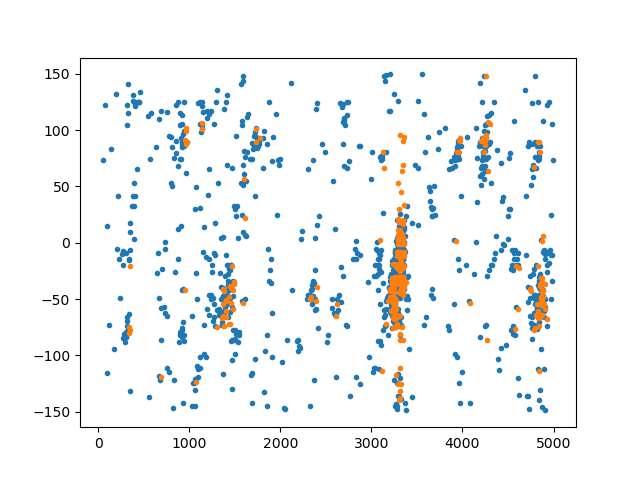

In [22]:
s,CA3_lfp,CA1_lfp,CA3_lfp_t,CA1_lfp_t,CA3_lfp_s,CA1_lfp_s = stim_cue_net(conn_CA3_to_CA3,conn_CA3_to_CA1,5000,placerange_to_indexes(-110,-90,pf_CA3),2000,cue_weight=50,seed=6)

lfp_sig_ts = np.arange(0,np.max(CA3_lfp_t),1)+1
CA3_lfp_sig = np.zeros(len(lfp_sig_ts))
CA1_lfp_sig = np.zeros(len(lfp_sig_ts))
CA3_senders = np.unique(CA3_lfp_s)
CA1_senders = np.unique(CA1_lfp_s)

for send in CA3_senders:
    # interpolate the LFP signal
    f = interpolate.interp1d(CA3_lfp_t[CA3_lfp_s==send],CA3_lfp[CA3_lfp_s==send],fill_value='extrapolate')
    CA3_lfp_sig += f(lfp_sig_ts)

for send in CA1_senders:
    # interpolate the LFP signal
    f = interpolate.interp1d(CA1_lfp_t[CA1_lfp_s==send],CA1_lfp[CA1_lfp_s==send],fill_value='extrapolate')
    CA1_lfp_sig += f(lfp_sig_ts)

s_times = s['times']
s_senders = s['senders']
s_place_CA1 = np.zeros(len(s_times))
s_place_CA3 = np.zeros(len(s_times))

for i in range(len(s_times)):
    if s_senders[i] < len(pf_CA1)+1250 and s_senders[i] >= 1250:
        s_place_CA1[i] = pf_CA1[s_senders[i]-1250]
        s_place_CA3[i] = np.nan
    elif s_senders[i] < len(pf_CA3):
        s_place_CA3[i] = pf_CA3[s_senders[i]]
        s_place_CA1[i] = np.nan
    else:
        s_place_CA1[i] = np.nan
        s_place_CA3[i] = np.nan

plt.close('all')
plt.figure()
plt.plot(s_times,s_place_CA3,'.')
plt.plot(s_times,s_place_CA1,'.')
plt.show()

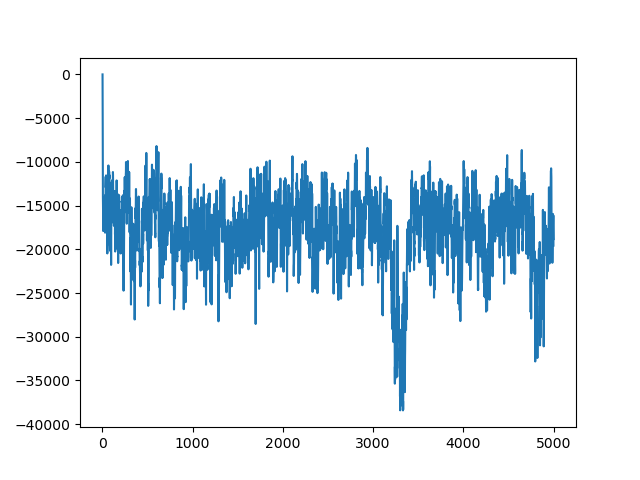

In [23]:
plt.close('all')
plt.figure()
plt.plot(lfp_sig_ts,CA3_lfp_sig)
plt.show()